In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from google.colab import drive
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

dataset_path = "/content/drive/MyDrive/DA project 2-20250328T145121Z-001/DA project 2"
img_width, img_height = 128, 128
batch_size = 32


In [ ]:
# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical'  # Use 'categorical' for multi-class classification
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical'
)

# Get the class names from the training dataset
class_names = train_ds.class_names


Found 5631 files belonging to 6 classes.
Using 4505 files for training.
Found 5631 files belonging to 6 classes.
Using 1126 files for validation.


In [ ]:
# Augmentation layer (adjust parameters as needed)
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

# Apply augmentation to the training dataset
def augment_data(image, label):
    image = data_augmentation(image)
    # Rescale image (if needed)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(augment_data)

# Preprocess validation dataset (only rescaling)
def preprocess_val_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Rescale image
    return image, label

val_ds = val_ds.map(preprocess_val_data)


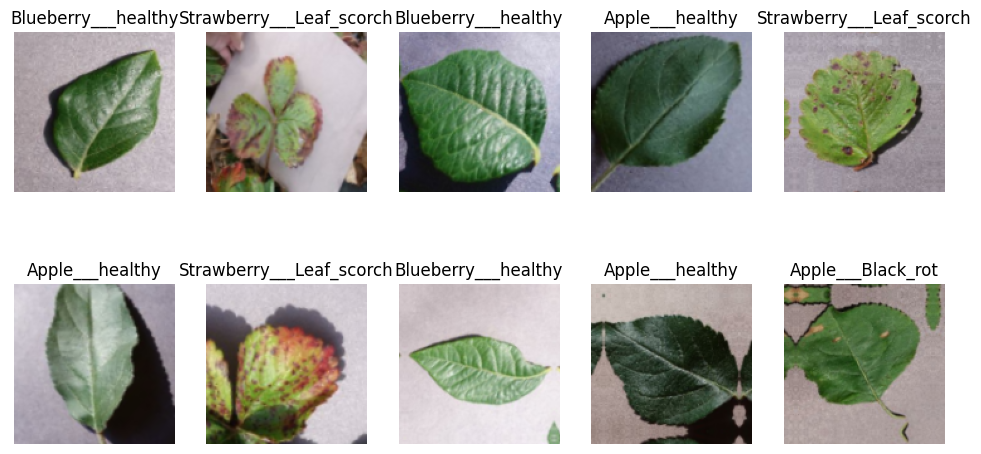

In [ ]:
# Fetch a batch of images and labels
images, labels = next(iter(train_ds))  # Using 'train_ds' directly instead of 'train_generator'

# Plot the first 10 images from the batch
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])  # Get class label
    plt.axis('off')
plt.show()


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40
)

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f" Training Accuracy: {train_acc:.4f}")
print(f" Validation Accuracy: {val_acc:.4f}")

# Evaluate on validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,831,622 (6.99 MB)

 Trainable params: 1,831,622 (6.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 2051s 15s/step - accuracy: 0.3907 - loss: 1.4448 - val_accuracy: 0.6581 - val_loss: 0.8118
Epoch 2/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - accuracy: 0.7094 - loss: 0.7812 - val_accuracy: 0.8188 - val_loss: 0.5049
Epoch 3/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.8125 - loss: 0.5359 - val_accuracy: 0.8242 - val_loss: 0.5319
Epoch 4/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - accuracy: 0.8612 - loss: 0.4082 - val_accuracy: 0.8677 - val_loss: 0.3398
Epoch 5/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 27s 190ms/step - accuracy: 0.8845 - loss: 0.3259 - val_accuracy: 0.9174 - val_loss: 0.2178
Epoch 6/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.9050 - loss: 0.2867 - val_accuracy: 0.9307 - val_loss: 0.2220
Epoch 7/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.9095 - loss: 0.2958 - val_accuracy: 0.9201 - val_loss: 0.2431
Epoch 8/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 0.9102 - loss: 0

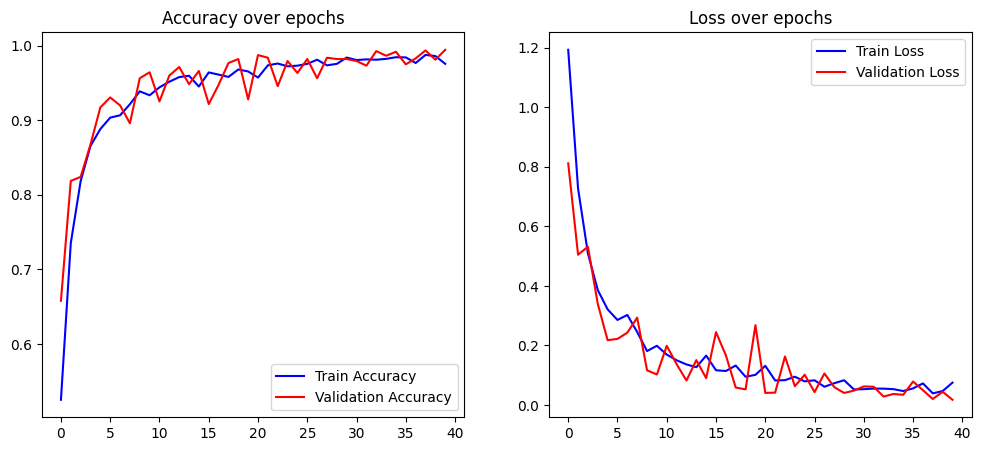

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

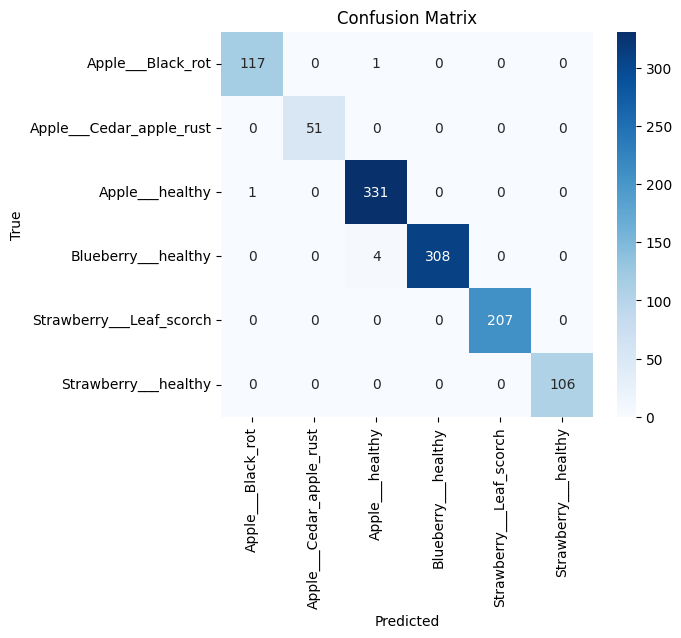

Classification Report:
                           precision    recall  f1-score   support

       Apple___Black_rot       0.99      0.99      0.99       118
Apple___Cedar_apple_rust       1.00      1.00      1.00        51
         Apple___healthy       0.99      1.00      0.99       332
     Blueberry___healthy       1.00      0.99      0.99       312
Strawberry___Leaf_scorch       1.00      1.00      1.00       207
    Strawberry___healthy       1.00      1.00      1.00       106

                accuracy                           0.99      1126
               macro avg       1.00      1.00      1.00      1126
            weighted avg       0.99      0.99      0.99      1126


Type I and II error analysis is generally for binary classification. For multi-class, use per-class confusion matrix.


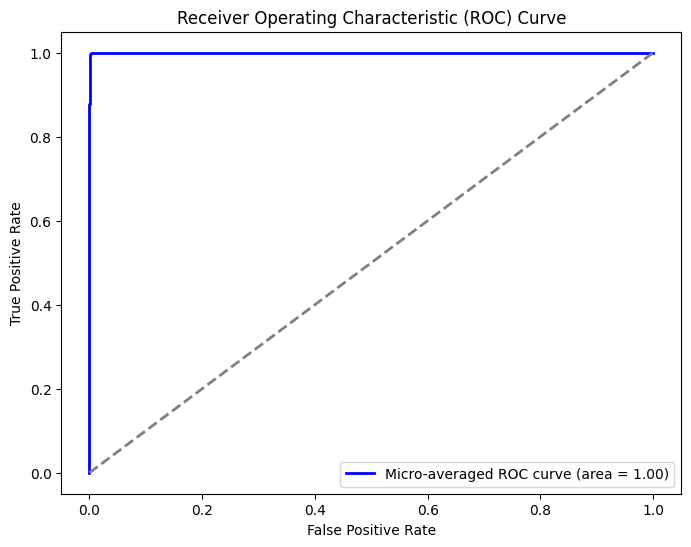


Z-test: z = -1.155, p-value = 0.2479
T-test: t = -1.155, p-value = 0.2484
Variance Test (Levene): W = 0.009, p-value = 0.9263


In [ ]:
# Plot learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss over epochs')
plt.legend()
plt.show()

# Get predictions and true labels
y_true = []
y_pred_prob = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_prob.extend(model.predict(images))

y_pred_prob = np.array(y_pred_prob)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.array(y_true)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Type I & II Errors (example for binary classification or one-vs-rest)
if len(class_names) == 2:
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"\nType I Error (False Positive): {fp}")
    print(f"Type II Error (False Negative): {fn}")
else:
    print("\nType I and II error analysis is generally for binary classification. For multi-class, use per-class confusion matrix.")

# ROC Curve (micro-average for multi-class)
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Micro-averaged ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Statistical Tests
# 1. Z-test (for large samples)
import scipy.stats as stats

mean_diff = np.mean(y_pred - y_true)
std_diff = np.std(y_pred - y_true)
z_score = mean_diff / (std_diff / np.sqrt(len(y_true)))
p_z = 2 * (1 - stats.norm.cdf(abs(z_score))) # Now 'stats' is defined
print(f"\nZ-test: z = {z_score:.3f}, p-value = {p_z:.4f}")

# 2. T-test (paired)
t_stat, p_t = stats.ttest_rel(y_pred, y_true)
print(f"T-test: t = {t_stat:.3f}, p-value = {p_t:.4f}")

# 3. Variance Test (Levene's Test)
levene_stat, p_var = stats.levene(y_pred, y_true)
print(f"Variance Test (Levene): W = {levene_stat:.3f}, p-value = {p_var:.4f}")
